In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from torch.utils.data import DataLoader
import analysis_utils
from counterfactual_datasets.entity_tracking import *
import seaborn as sns
from baukit import TraceDict
from einops import rearrange, einsum

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualizing Attention Pattern

In [2]:
path = "./llama_7b/"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


In [3]:
data_file = "./box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "./box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 8

In [4]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=batch_size,
    data_file=data_file,
    # object_file=object_file,
    few_shot=False,
    alt_examples=True,
    # num_ents_or_ops=3,
    architecture="LLaMAForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 8


In [5]:
_, head_groups = analysis_utils.get_circuit_components(model)

40 15 30 5


In [10]:
scaled_attn.shape

torch.Size([8, 32, 54, 54])

In [155]:
inputs = next(enumerate(dataloader))[1]
scaled_attn = {}
for layer_idx in [21, 14, 10, 8]:
    with TraceDict(
        model, [f"model.layers.{layer_idx}.self_attn.v_proj"], retain_input=True
    ) as trace:
        outputs = model(input_ids=inputs["input_ids"].to(device), output_attentions=True)

    input_ids = inputs["input_ids"].to("cpu")

    attn_score = outputs.attentions[layer_idx]
    value_vector = trace[f"model.layers.{layer_idx}.self_attn.v_proj"].output
    value_vector = rearrange(
        value_vector,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    value_vector_norm = torch.norm(value_vector, dim=-1)
    scaled_attn[layer_idx] = einsum(
        value_vector_norm,
        attn_score,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

del outputs, trace
torch.cuda.empty_cache()

In [168]:
tokens = [tokenizer.decode(token_idx) for token_idx in inputs["input_ids"][4]]

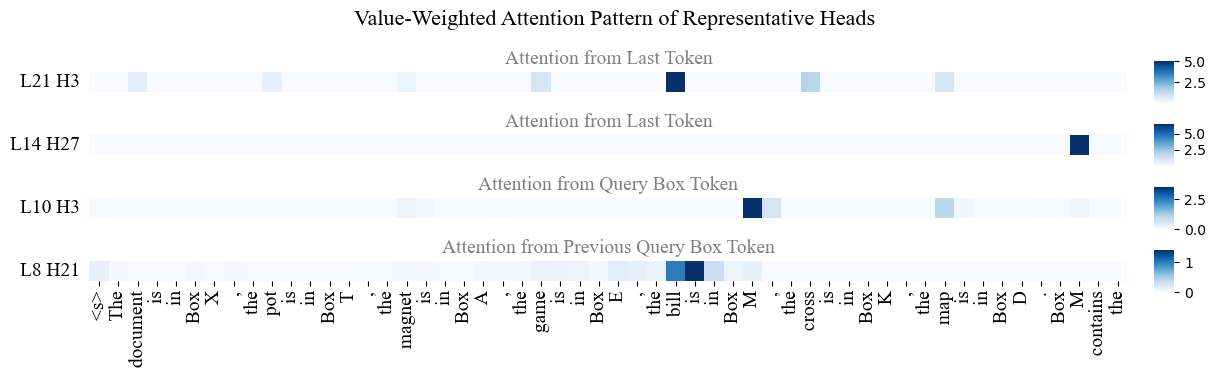

In [261]:
fig, axes = plt.subplots(
    4,
    2,
    gridspec_kw={
        "height_ratios": [1, 1, 1, 1],
        "width_ratios": [50, 1],
        "wspace": 0.05,
        "hspace": 0.5,
    },
    sharex="col",
    figsize=(14, 3),
)

sns.heatmap(
    scaled_attn[21][4:5, 3, -1].detach().cpu().numpy(),
    ax=axes[0][0],
    cmap="Blues",
    cbar_ax=axes[0][1],
    cbar_kws={"shrink": 5.5},
    square=True,
)
sns.heatmap(
    scaled_attn[14][4:5, 27, -1].detach().cpu().numpy(),
    ax=axes[1][0],
    cmap="Blues",
    cbar_ax=axes[1][1],
    cbar_kws={"shrink": 5.5},
    square=True,
)
sns.heatmap(
    scaled_attn[10][4:5, 3, -3].detach().cpu().numpy(),
    ax=axes[2][0],
    cmap="Blues",
    cbar_ax=axes[2][1],
    cbar_kws={"shrink": 5.5},
    square=True,
)
sns.heatmap(
    scaled_attn[8][4:5, 21, 34].detach().cpu().numpy(),
    ax=axes[3][0],
    cmap="Blues",
    cbar_ax=axes[3][1],
    cbar_kws={"shrink": 5.5},
    square=True,
)

for i, ax in enumerate(fig.get_axes()):
    if i != 6:
        ax.tick_params(bottom=False, labelbottom=False, left=False)
    else:
        ax.tick_params(left=False)

axes[3][0].set_xticklabels(tokens, rotation=90, fontdict={"family": "Times New Roman", "size": 14})

axes[0][0].set_title(
    "Attention from Last Token", fontdict={"family": "Times New Roman", "size": 14, "color": "gray"}
)
axes[0][0].set_yticklabels(
    ["L21 H3"], rotation=0, fontdict={"family": "Times New Roman", "size": 14}
)

axes[1][0].set_title(
    "Attention from Last Token", fontdict={"family": "Times New Roman", "size": 14, "color": "gray"}
)
axes[1][0].set_yticklabels(
    ["L14 H27"], rotation=0, fontdict={"family": "Times New Roman", "size": 14}
)

axes[2][0].set_title(
    "Attention from Query Box Token",
    fontdict={"family": "Times New Roman", "size": 14, "color": "gray"},
)
axes[2][0].set_yticklabels(
    ["L10 H3"], rotation=0, fontdict={"family": "Times New Roman", "size": 14}
)

axes[3][0].set_title(
    "Attention from Previous Query Box Token",
    fontdict={"family": "Times New Roman", "size": 14, "color": "gray"},
)
axes[3][0].set_yticklabels(
    ["L8 H21"], rotation=0, fontdict={"family": "Times New Roman", "size": 14}
)

# figure title
fig.suptitle(
    "Value-Weighted Attention Pattern of Representative Heads",
    fontsize=16,
    fontfamily="Times New Roman",
    y=1.05,
)

plt.savefig("./figures/attention_pattern.pdf", dpi=200, bbox_inches="tight")

In [176]:
fig.get_axes()

[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

## Semantic Info Flow

In [3]:
path = "./new_masks/llama-7b"
head_groups = sorted([mask for mask in os.listdir(path)])

In [4]:
data = {}
for head_group in head_groups:
    data[head_group] = {}
    for desiderata in ["box_label_value", "object_value", "positional"]:
        with open(f"./new_masks/llama-7b/{head_group}/{desiderata}/0.01.txt", "r") as f:
            file_content = f.read()
            data[head_group][desiderata] = float(file_content.split("\n")[1].split(": ")[1])

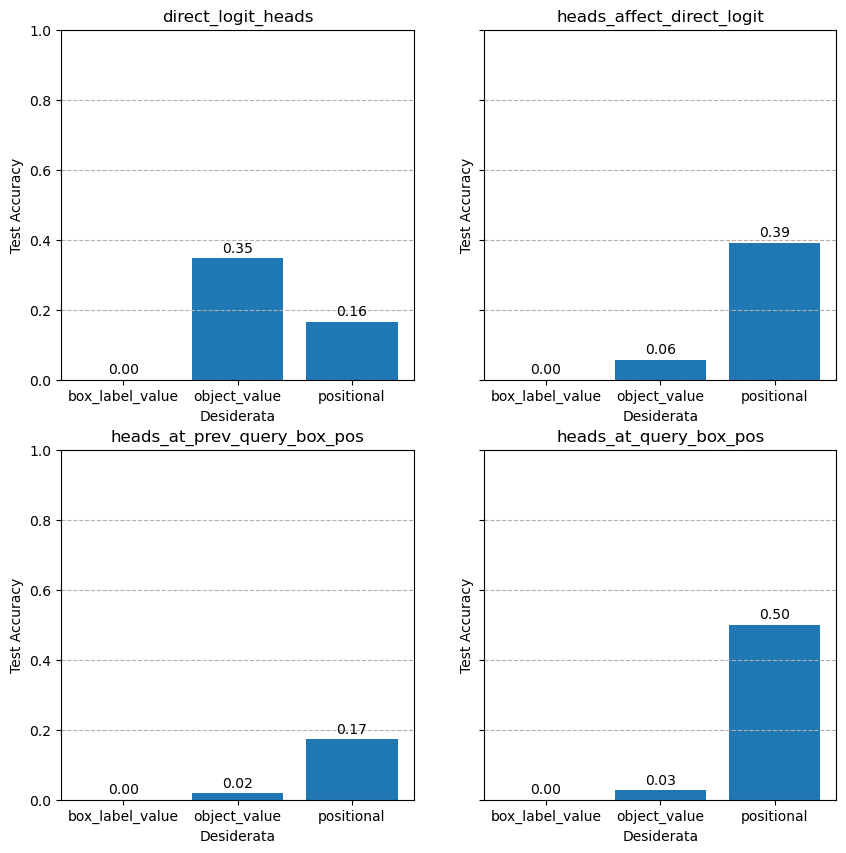

In [5]:
# Plot 4 subplots for each head group
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for i, head_group in enumerate(head_groups):
    axs[i].bar(data[head_group].keys(), data[head_group].values())
    axs[i].set_title(head_group)
    axs[i].set_ylim([0, 1])
    axs[i].set_ylabel("Test Accuracy")
    axs[i].set_xlabel("Desiderata")
    axs[i].grid(True, axis="y", linestyle="--")

# Annotation the accuracy values
for i, head_group in enumerate(head_groups):
    for desiderata in data[head_group].keys():
        axs[i].annotate(
            f"{data[head_group][desiderata]:.2f}",
            xy=(desiderata, data[head_group][desiderata] + 0.01),
            ha="center",
            va="bottom",
        )

plt.show()

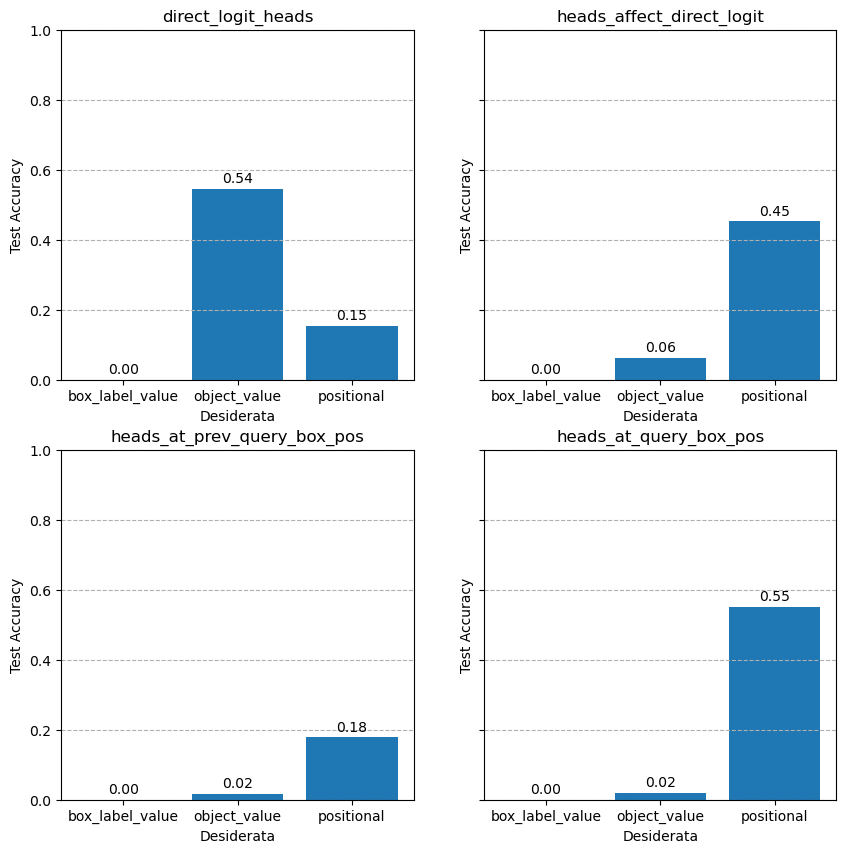

In [42]:
# Plot 4 subplots for each head group
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for i, head_group in enumerate(head_groups):
    axs[i].bar(data[head_group].keys(), data[head_group].values())
    axs[i].set_title(head_group)
    axs[i].set_ylim([0, 1])
    axs[i].set_ylabel("Test Accuracy")
    axs[i].set_xlabel("Desiderata")
    axs[i].grid(True, axis="y", linestyle="--")

# Annotation the accuracy values
for i, head_group in enumerate(head_groups):
    for desiderata in data[head_group].keys():
        axs[i].annotate(
            f"{data[head_group][desiderata]:.2f}",
            xy=(desiderata, data[head_group][desiderata] + 0.01),
            ha="center",
            va="bottom",
        )

plt.show()

## Cross-Model Patching Results

In [11]:
patching_scores = {
    "Value Fetcher": 75.83,
    "Query Box Attender": 78.33,
    "Previous Box Label Attender": 66.17,
    "Context Aggregator": 67.33,
    "Value Fetcher + Query Box Attender": 79.67,
    "All Head Groups": 79.5,
}

In [28]:
# # Plot patching scores using bar plot
# plt.figure(figsize=(8, 5))
# plt.bar(patching_scores.keys(), patching_scores.values(), alpha=0.75)
# plt.ylim([0, 100])
# plt.ylabel("Test Accuracy")
# plt.xlabel("Head Groups")
# plt.title("Acc After Patching Inputs of Value Fetcher Heads (Goat -> Llama)")
# plt.xticks(rotation=45)
# plt.yticks(range(0, 110, 10))
# plt.grid(True, axis="y", linestyle="--")

# # Insert a horizontal line at 67%
# plt.axhline(y=66.5, color="r", linestyle="--", label="Llama-7b")
# plt.axhline(y=82, color="g", linestyle="--", label="Goat-7b")
# plt.legend()

# plt.show()

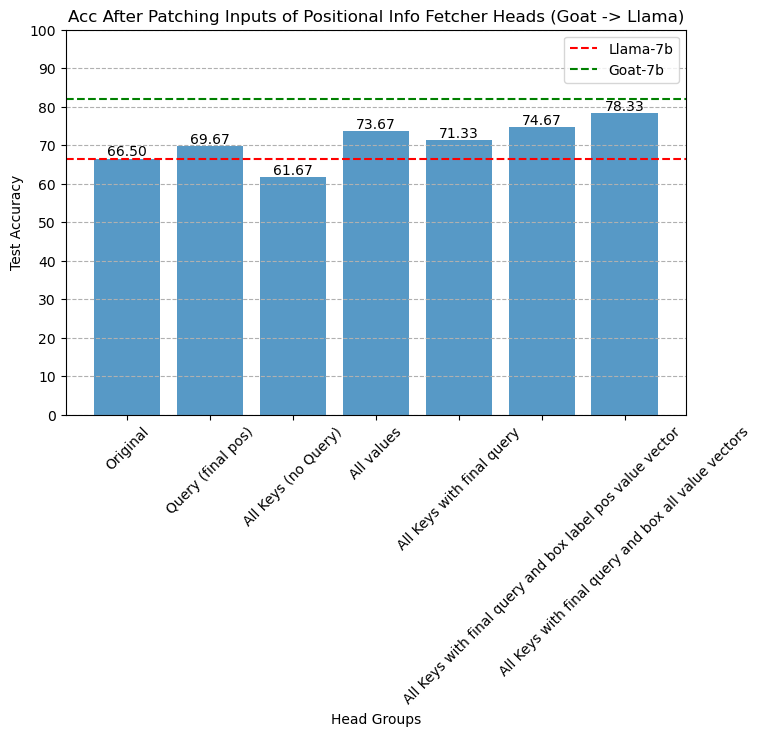

In [31]:
# Positional Info Heads
# Original - 66.5
# Query (final pos) - 69.67
# All Keys (no Query) - 61.67
# All values - 73.67
# All Keys with final query - 71.33
# All Keys with final query and box label pos value vector - 74.67
# All Keys with final query and box all value vectors - 78.33

# Create a dictionary using above information
patching_scores = {
    "Original": 66.5,
    "Query (final pos)": 69.67,
    "All Keys (no Query)": 61.67,
    "All values": 73.67,
    "All Keys with final query": 71.33,
    "All Keys with final query and box label pos value vector": 74.67,
    "All Keys with final query and box all value vectors": 78.33,
}

# Plot patching scores using bar plot
plt.figure(figsize=(8, 5))
plt.bar(patching_scores.keys(), patching_scores.values(), alpha=0.75)
plt.ylim([0, 100])
plt.ylabel("Test Accuracy")
plt.xlabel("Head Groups")
plt.title("Acc After Patching Inputs of Positional Info Fetcher Heads (Goat -> Llama)")
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10))
plt.grid(True, axis="y", linestyle="--")

# Insert a horizontal line at 67%
plt.axhline(y=66.5, color="r", linestyle="--", label="Llama-7b")
plt.axhline(y=82, color="g", linestyle="--", label="Goat-7b")
plt.legend()

# Annotation the accuracy values
for desiderata in patching_scores.keys():
    plt.annotate(
        f"{patching_scores[desiderata]:.2f}",
        xy=(desiderata, patching_scores[desiderata] + 0.01),
        ha="center",
        va="bottom",
    )

plt.show()

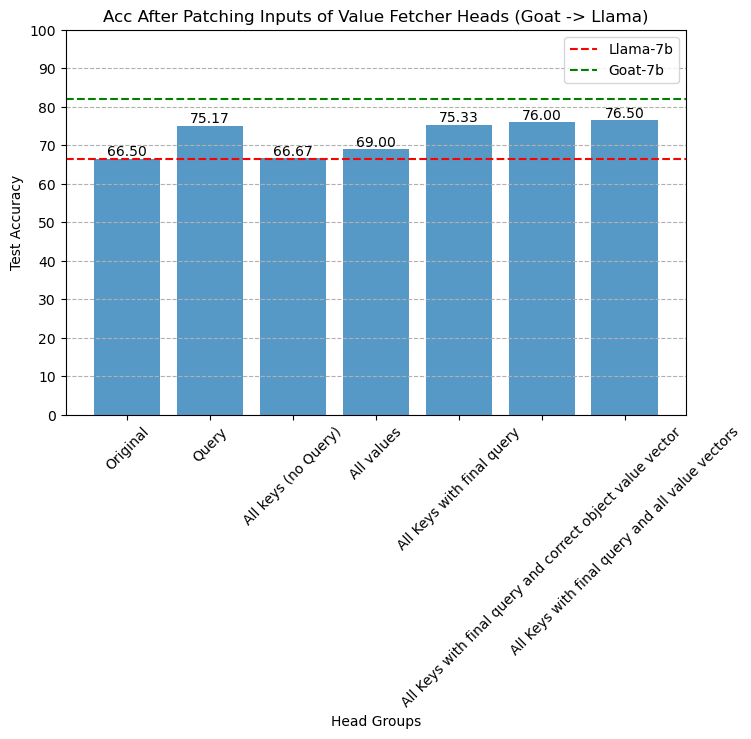

: 

In [32]:
# Direct Logit Heads
# Original - 66.5
# Query - 75.17
# All keys (no Query) - 66.67
# All values - 69.0
# All Keys with final query -75.33
# All Keys with final query and correct object value vector - 76.0
# All Keys with final query and all value vectors - 76.5

# Create a dictionary using above information
patching_scores = {
    "Original": 66.5,
    "Query": 75.17,
    "All keys (no Query)": 66.67,
    "All values": 69.0,
    "All Keys with final query": 75.33,
    "All Keys with final query and correct object value vector": 76.0,
    "All Keys with final query and all value vectors": 76.5,
}

# Plot patching scores using bar plot
plt.figure(figsize=(8, 5))
plt.bar(patching_scores.keys(), patching_scores.values(), alpha=0.75)
plt.ylim([0, 100])
plt.ylabel("Test Accuracy")
plt.xlabel("Head Groups")
plt.title("Acc After Patching Inputs of Value Fetcher Heads (Goat -> Llama)")
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10))
plt.grid(True, axis="y", linestyle="--")

# Insert a horizontal line at 67%
plt.axhline(y=66.5, color="r", linestyle="--", label="Llama-7b")
plt.axhline(y=82, color="g", linestyle="--", label="Goat-7b")
plt.legend()

# Annotation the accuracy values
for desiderata in patching_scores.keys():
    plt.annotate(
        f"{patching_scores[desiderata]:.2f}",
        xy=(desiderata, patching_scores[desiderata] + 0.01),
        ha="center",
        va="bottom",
    )

plt.show()

In [30]:
input_patching_score = {"query": 75.17, "key": 66.33, "value": 67.0}

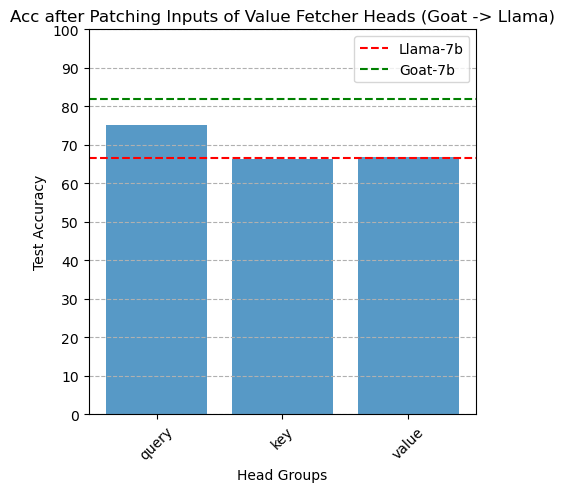

In [47]:
# Plot patching scores using bar plot
plt.figure(figsize=(5, 5))
plt.bar(input_patching_score.keys(), input_patching_score.values(), alpha=0.75)
plt.ylim([0, 100])
plt.ylabel("Test Accuracy")
plt.xlabel("Head Groups")
plt.title("Acc after Patching Inputs of Value Fetcher Heads (Goat -> Llama)")
plt.xticks(rotation=45)
plt.yticks(range(0, 110, 10))
plt.grid(True, axis="y", linestyle="--")

# Insert a horizontal line at 67%
plt.axhline(y=66.5, color="r", linestyle="--", label="Llama-7b")
plt.axhline(y=82, color="g", linestyle="--", label="Goat-7b")
plt.legend()

plt.show()

## Cross-Model Activation Patching 